# RelBench Arxiv Dataset - Graph Edge Author Citation
We use the RelBench arxiv dataset [here][1]. We build a graph using authors as nodes with citation as edges. We define binary classification targets are "Did author publish in 2022?". We build graph and features from information before 2022.

[1]: https://relbench.stanford.edu/datasets/rel-arxiv/

# Load and Convert RelBench Arxiv Data

In [1]:
import os
os.environ["RELBENCH_CACHE_DIR"] = "/raid/cdeotte/.cache/relbench/rel-arxiv/"

VER=10

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [3]:
from relbench.datasets import get_dataset
dataset = get_dataset("rel-arxiv")

In [4]:
db = dataset.get_db()

Loading Database object from /raid/cdeotte/.cache/relbench/rel-arxiv//rel-arxiv/db...
Done in 1.21 seconds.


In [5]:
db.table_dict.keys()

dict_keys(['papers', 'citations', 'categories', 'paperCategories', 'paperAuthors', 'authors'])

In [6]:
dfs = []
for name, tbl in db.table_dict.items():
    df = tbl.df
    print(f"\n=== {name} ===")
    print(df.shape)
    display(df.head())
    dfs.append(df)


=== papers ===
(193696, 7)


,Paper_ID,arXiv_Code,Title,Abstract,Submission_Date,DOI,Primary_Category_ID
0,0,arXiv:1801.01549,Moving unstable particles and special relativity,In Poincare-Wigner-Dirac theory of relativisti...,2018-01-01,10.1155/2018/4657079,0
1,1,arXiv:1801.00403,Exact eigenfunction amplitude distributions of...,The exact probability distributions of the amp...,2018-01-01,10.1063/1.5006320,7
2,2,arXiv:1801.00401,Floquet engineering of multi-orbital Mott insu...,We consider driving multi-orbital Mott insulat...,2018-01-01,10.1103/PhysRevLett.121.107201,13
3,3,arXiv:1801.00395,Factorization of Standard Model cross sections...,The factorization theorem for organizing multi...,2018-01-01,10.1103/PhysRevD.97.053006,6
4,4,arXiv:1712.08944,The independence of neutral and ionized gas ou...,Using a large sample of emission line galaxies...,2018-01-01,10.3847/1538-4357/aaa42d,16



=== citations ===
(1223361, 3)


,Paper_ID,References_Paper_ID,Submission_Date
0,27,16096,2018-01-01
1,37,16955,2018-01-01
2,40,153595,2018-01-01
3,3,1715,2018-01-01
4,8,71985,2018-01-01



=== categories ===
(53, 2)


,Category_ID,Category
0,0,42
1,1,10
2,2,52
3,3,16
4,4,17



=== paperCategories ===
(133060, 3)


,Paper_ID,Category_ID,Submission_Date
0,26,22,2018-01-01
1,26,34,2018-01-01
2,28,1,2018-01-01
3,29,23,2018-01-01
4,30,23,2018-01-01



=== paperAuthors ===
(452251, 3)


,Paper_ID,Author_ID,Submission_Date
0,0,0,2018-01-01
1,35,1,2018-01-01
2,35,2,2018-01-01
3,35,3,2018-01-01
4,35,4,2018-01-01



=== authors ===
(143691, 3)


,Author_ID,Name,ORCID
0,0,Stefanovich Eugene V.,http://orcid.org/0000-0002-8973-7804
1,1,Fonin Mikhail,http://orcid.org/0000-0003-3015-0045
2,2,Wietstruk Marko,http://orcid.org/0000-0002-1949-283X
3,3,Böttcher Stefan,http://orcid.org/0000-0002-1058-8480
4,4,Koch Roland J.,http://orcid.org/0000-0001-5748-8463


# Create Author Targets (After Jan 1, 2022)
We define target as "Did author published paper in 2022?"

In [7]:
T = pd.Timestamp("2022-01-01")
T_end = T + pd.DateOffset(years=1)

authors_df = db.table_dict["authors"].df.copy()
paper_authors_df = db.table_dict["paperAuthors"].df.copy()
paper_authors_df["Submission_Date"] = pd.to_datetime(
    paper_authors_df["Submission_Date"]
)

future_authors = (
    paper_authors_df.loc[
        (paper_authors_df["Submission_Date"] > T) &
        (paper_authors_df["Submission_Date"] <= T_end),
        "Author_ID"
    ]
    .drop_duplicates()
)

author_targets = (
    authors_df[["Author_ID"]]
    .assign(
        target=lambda df: df["Author_ID"].isin(future_authors).astype("int8")
    )
)

author_targets.head()

,Author_ID,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [8]:
print("Target counts distribution:")
author_targets["target"].value_counts(normalize=True)

Target counts distribution:


target
0    0.561754
1    0.438246
Name: proportion, dtype: float64

# Create Author (as Nodes) Graph (Before Jan 1, 2022)
Find author edges based on citation info before 2022

In [9]:
from collections import Counter, defaultdict
import pandas as pd

T = pd.Timestamp("2022-01-01")

# --------------------------------------------------
# Load tables
# --------------------------------------------------
paper_authors = db.table_dict["paperAuthors"].df.copy()
citations     = db.table_dict["citations"].df.copy()

paper_authors["Submission_Date"] = pd.to_datetime(paper_authors["Submission_Date"])
citations["Submission_Date"] = pd.to_datetime(citations["Submission_Date"])

# --------------------------------------------------
# Restrict to pre-2022 (CRITICAL for no leakage)
# --------------------------------------------------
paper_authors_2021 = paper_authors[
    paper_authors["Submission_Date"] < T
]

citations_2021 = citations[
    citations["Submission_Date"] < T
]

# --------------------------------------------------
# Paper → Authors mapping
# --------------------------------------------------
paper_to_authors = (
    paper_authors_2021
    .groupby("Paper_ID")["Author_ID"]
    .apply(list)
    .to_dict()
)

# --------------------------------------------------
# Author → Author citation counter (DIRECTED)
# --------------------------------------------------
citation_counter = defaultdict(Counter)

for _, row in citations_2021.iterrows():
    citing_paper = row["Paper_ID"]
    cited_paper  = row["References_Paper_ID"]

    citing_authors = paper_to_authors.get(citing_paper)
    cited_authors  = paper_to_authors.get(cited_paper)

    if not citing_authors or not cited_authors:
        continue

    for a_src in citing_authors:
        for a_dst in cited_authors:
            if a_src == a_dst:
                continue
            citation_counter[a_src][a_dst] += 1

# --------------------------------------------------
# Same-style extractor as coauthor version
# --------------------------------------------------
def extract_citations(author_id):
    counter = citation_counter.get(author_id, {})
    if not counter:
        return [], []
    ids = [int(k) for k in counter.keys()]
    counts = [int(v) for v in counter.values()]
    return ids, counts

# --------------------------------------------------
# Attach to author_targets
# --------------------------------------------------
citation_data = author_targets["Author_ID"].apply(extract_citations)

author_targets["citation_ids"] = citation_data.apply(lambda x: x[0])
author_targets["citation_counts"] = citation_data.apply(lambda x: x[1])

author_targets.head()

,Author_ID,target,citation_ids,citation_counts
0,0,0,[],[]
1,1,0,[],[]
2,2,0,[],[]
3,3,0,[],[]
4,4,1,"[2905, 2819, 2906, 2907, 2908, 2909, 6, 5, 308...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [10]:
print("Percentage authors without co-authors:")
(author_targets["citation_ids"].str.len() == 0).mean()

Percentage authors without co-authors:


np.float64(0.4513226298098002)

# Graph EDA

In [11]:
author_targets["degree"] = author_targets["citation_ids"].apply(len)

deg = author_targets["degree"]

stats = {
    "num_authors": len(deg),
    "fraction_isolated": (deg == 0).mean(),
    "mean_degree": deg.mean(),
    "median_degree": deg.median(),
    "max_degree": deg.max(),
}

stats

{'num_authors': 143691,
 'fraction_isolated': np.float64(0.4513226298098002),
 'mean_degree': np.float64(36.92478304138742),
 'median_degree': np.float64(2.0),
 'max_degree': np.int64(2798)}

In [12]:
deg_pos = deg[deg > 0]
{
    "mean_degree_nonzero": deg_pos.mean(),
    "median_degree_nonzero": deg_pos.median(),
}

{'mean_degree_nonzero': np.float64(67.29780568239472),
 'median_degree_nonzero': np.float64(15.0)}

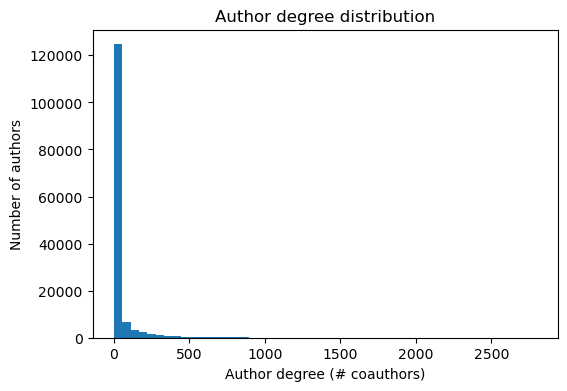

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(deg, bins=50)
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors")
plt.title("Author degree distribution")
plt.show()

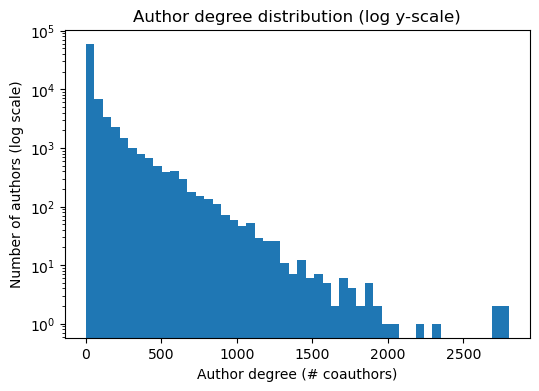

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(deg[deg > 0], bins=50)
plt.yscale("log")
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors (log scale)")
plt.title("Author degree distribution (log y-scale)")
plt.show()

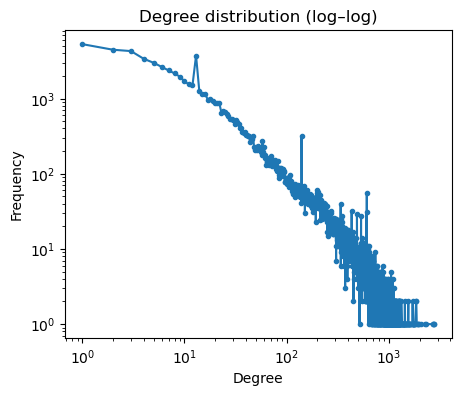

In [15]:
counts = deg.value_counts().sort_index()
counts = counts[counts.index > 0]

plt.figure(figsize=(5, 4))
plt.plot(counts.index, counts.values, marker=".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution (log–log)")
plt.show()

In [16]:
all_edge_weights = np.concatenate(
    author_targets["citation_counts"].values
)
pd.Series(all_edge_weights).describe()

count    5.305759e+06
mean     2.672378e+00
std      7.134085e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.840000e+02
dtype: float64

In [17]:
print("Repeat collaborations 2:")
print( (pd.Series(all_edge_weights) >= 2).mean() )   
print("Repeat collaborations 5:")
print( (pd.Series(all_edge_weights) >= 5).mean() )

Repeat collaborations 2:
0.34454750017857955
Repeat collaborations 5:
0.09374907529723835


# Save Data

In [18]:
author_targets.to_parquet(f"data/author_targets_v{VER}.pqt",index=False)